In [1]:
import pandas as pd
import numpy as np
from scripts import *
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# importing main data
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
missing_vals = pd.read_csv('bedroomsfilled.csv')
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')

# import additional zipcode data
zipcode_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx', index_col='zipcode')
clean_data(training_data)
clean_data(missing_vals)

#replaced missing values with correct info from zillow.
training_data = no_bedrooms(training_data, missing_vals)


#replace 33 bedrooms with correct value
training_data.set_value(8597, 'bedrooms', 3).head(3)

(17290, 22)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month
0,2591820310,365000.0,4,2.25,2070,8893,2.0,0,0,4,...,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,10
1,7974200820,865000.0,5,3.00,2900,6730,1.0,0,0,5,...,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,8
2,7701450110,1038000.0,4,2.50,3770,10893,2.0,0,2,3,...,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,8


In [3]:
training_data = pd.merge(training_data, zipcode_data, how='right', on='zipcode')
training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']

# Log Transform Square Feet

In [4]:
training_data

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,median_home_value,total_housing_units,land_area,water_area_sq_mile,owned_household_with_mortgage,renter_occupied_households,houses_owned_outright,sold_and_unoccupied,seasonal_or_rec_use,available_housing
0,2591820310,365000.0,4,2.25,2070,8893,2.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
1,5112800060,455000.0,4,1.75,2050,94525,1.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
2,1423400260,273000.0,3,1.75,2050,9045,2.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
3,1423200170,223000.0,2,1.00,910,9869,1.0,0,0,3,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
4,1402100070,335500.0,5,3.00,2240,19090,1.0,0,0,4,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2425049107,1950000.0,4,3.75,4150,17424,1.0,0,0,3,...,1000001,1163,1.44,4.30,567,116,379,9,19,101
17286,2210500010,2450000.0,7,4.25,4670,23115,2.0,0,2,3,...,1000001,1163,1.44,4.30,567,116,379,9,19,101
17287,3025300226,2100000.0,4,1.75,3550,19865,2.0,0,0,3,...,1000001,1163,1.44,4.30,567,116,379,9,19,101
17288,3025300250,1620000.0,4,2.25,2350,17709,2.0,0,0,4,...,1000001,1163,1.44,4.30,567,116,379,9,19,101


In [5]:
# data_log = pd.DataFrame([])
# training_data['sqft_above'] = np.log(training_data['sqft_above'])
# training_data['sqft_living15'] = np.log(training_data['sqft_living15'])
# training_data['sqft_lot15'] = np.log(training_data['sqft_lot15'])
# training_data['sqft_living'] = np.log(training_data['sqft_living'])
# sns.distplot(training_data['sqft_above']);
# sns.distplot(training_data['sqft_living15']);
# sns.distplot(training_data['sqft_lot15']);
# sns.distplot(training_data['sqft_living']);

# Min/Max Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_feat = ['pop_density',
               'sqft_living15', 
               'sqft_above', 
               'sqft_basement',
               'bedrooms',
               'bathrooms',
               'median_household_income',
               'median_home_value',
               'sqft_lot']


training_data[scaled_feat] = scaler.fit_transform(training_data[scaled_feat])  

# Creating Dummies For Categorical Variables

In [7]:
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)


training_data = training_data.drop(['postoffice','id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)
training_data.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,365000.0,0.3,0.28125,2070,0.005041,2.0,0.195175,0.000000,1986,0,...,0,0,0,0,0,0,0,0,0,0
1,455000.0,0.3,0.21875,2050,0.056914,1.0,0.105263,0.165975,1959,0,...,0,0,0,0,0,0,0,0,0,0
2,273000.0,0.2,0.21875,2050,0.005133,2.0,0.192982,0.000000,1959,0,...,0,0,0,0,0,0,0,0,0,0
3,223000.0,0.1,0.12500,910,0.005632,1.0,0.067982,0.000000,1957,0,...,0,0,0,0,0,0,0,0,0,0
4,335500.0,0.4,0.37500,2240,0.011218,1.0,0.154605,0.112033,1968,0,...,0,0,0,0,0,0,0,0,0,0


# Removing Colinear Features

In [8]:
training_data.drop(['zip_98003',
                    'owned_household_with_mortgage', 
                    'houses_owned_outright',
                    'land_area',
                    'occupied_housing_units', 
                    'total_housing_units',
                    'sqft_living', 
                    'condition_3'], axis=1, inplace=True)

In [9]:
multicolinear_features(training_data) #graph should be empty

,cc
pairs,


# Sklearn Linear Model

In [10]:
y = training_data.price
x = training_data.drop(['price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 120), (3458, 120))

In [11]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('RMSE',np.sqrt(MSE).round(5))

RMSE 139487.47089


In [12]:
np.mean(cross_val_score(estimator=lr, X=x_train, y=y_train, cv=30))

0.8296363905845235

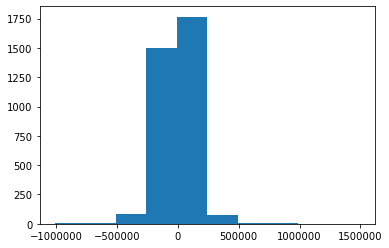

In [13]:
residuals = (y_test - y_hat)
plt.hist(residuals);

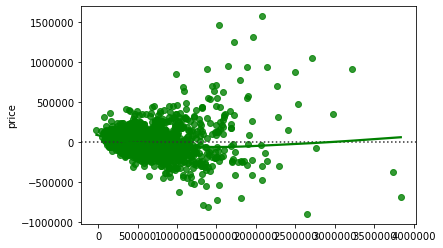

In [14]:
sns.residplot(y_hat, y_test, lowess=True, color='g')

# OLS Linear Model

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

outcome = 'price'
predictors = training_data.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum


model = ols(formula= formula, data=training_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     791.2
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:26:42   Log-Likelihood:            -2.3065e+05
No. Observations:               17290   AIC:                         4.615e+05
Df Residuals:                   17177   BIC:                         4.624e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1.334e+08   1.43e+07     -9.342      0.000   -1.61e+08   -1.05e+08
bedrooms                   -1.337e+05   1.71e+04     -7.807      0.000   -1.67e+05      -1e+05
bathrooms                   1.933e+05   2.23e+04      8.666      0.000     1.5e+05    2.37e+05
sqft_lot                    3.402e+05   6.39e+04      5.328      0.000    2.15e+05    4.65e+05
floors                     -2.918e+04   3358.058     -8.690      0.000   -3.58e+04   -2.26e+04
sqft_above                  1.539e+06   3.04e+04     50.693      0.000    1.48e+06     1.6e+06
sqft_basement               5.553e+05   1.81e+04     30.739      0.000     5.2e+05    5.91e+05
yr_built                    -252.6055     69.873     -3.615      0.000    -389.564    -115.647
yr_renovated                  28.7066      3.125      9.186      0.000      22.581      34.832
lat                         2.269e+05   6.64e+04      3.419      0.001    9.68e+04    3.57e+05
long                       -2.176e+05   4.73e+04     -4.598      0.000    -3.1e+05   -1.25e+05
sqft_living15                9.99e+04   1.78e+04      5.605      0.000     6.5e+04    1.35e+05
sqft_lot15                    -0.0561      0.062     -0.898      0.369      -0.179       0.066
sale_year                    6.05e+04   7853.246      7.704      0.000    4.51e+04    7.59e+04
population                  -706.8102     75.172     -9.403      0.000    -854.156    -559.465
pop_density                -1.126e+07   1.22e+06     -9.241      0.000   -1.36e+07   -8.87e+06
median_household_income    -1.427e+07   1.55e+06     -9.214      0.000   -1.73e+07   -1.12e+07
median_home_value          -8.376e+06   9.43e+05     -8.880      0.000   -1.02e+07   -6.53e+06
water_area_sq_mile         -2.763e+05   2.97e+04     -9.313      0.000   -3.34e+05   -2.18e+05
renter_occupied_households   807.4238     84.117      9.599      0.000     642.545     972.302
sold_and_unoccupied         9.411e+04   9978.894      9.431      0.000    7.46e+04    1.14e+05
seasonal_or_rec_use        -1.436e+04   1536.547     -9.345      0.000   -1.74e+04   -1.13e+04
available_housing             12.2037      1.405      8.685      0.000       9.450      14.958
waterf_1                    5.772e+05   1.64e+04     35.194      0.000    5.45e+05    6.09e+05
has_view_1                  7.828e+04   9617.410      8.139      0.000    5.94e+04    9.71e+04
has_view_2                  7.138e+04   5832.660     12.237      0.000    5.99e+04    8.28e+04
has_view_3                  1.388e+05   8013.357     17.316      0.000    1.23e+05    1.54e+05
has_view_4                  2.901e+05    1.2e+04     24.199      0.000    2.67e+05    3.14e+05
condition_2                -6666.5798   1.31e+04     -0.509      0.611   -3.23e+04     1.9e+04
condition_4                 2.637e+04   300